# CNN Image Classification Assignment 

## Import Libraries



explain tensorflow and keras

In [1]:
# TensorFlow and tf.keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tarfile as tarfile
from six.moves import cPickle as pickle
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
import tensorflow as tf
import tensorflow

## 1. loading the CIFAR-10 Dataset

This project uses the CIFAR-10 dataset, which consists of 60000  colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.The dataset homepage is https://www.cs.toronto.edu/~kriz/cifar.html. The images show individual articles of clothing at low resolution (32 by 32 pixels), as seen here:
Here 10,000 images are used to evaluate how accurately the network learned to classify images. CIFAR-10 dataset can be directly accessed from TensorFlow. But since we have tar file, here I load data from tar file

In [ ]:
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

 extract the tar file into batch file

In [3]:
filename = "/content/drive/MyDrive/8008/cifar-10-python.tar"
tf = tarfile.open(filename)
tf.extractall('/content/drive/MyDrive/8008/extract') 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read data from batch files

In [4]:
cifar10_dataset_folder_path='/content/drive/MyDrive/8008/extract/cifar-10-batches-py'
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    if batch_id in range(1,6):
      with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:# note the encoding type is 'latin1'
       batch = pickle.load(file, encoding='latin1')
    else:
      with open(cifar10_dataset_folder_path + '/test_batch' , mode='rb') as file:# note the encoding type is 'latin1'
       batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

features1, labels1=load_cfar10_batch(cifar10_dataset_folder_path,1)
features2, labels2=load_cfar10_batch(cifar10_dataset_folder_path,2)
features3, labels3=load_cfar10_batch(cifar10_dataset_folder_path,3)
features4, labels4=load_cfar10_batch(cifar10_dataset_folder_path,4)
features5, labels5=load_cfar10_batch(cifar10_dataset_folder_path,5)
train_images=np.concatenate((features1, features2,features3,features4,features5), axis=0)
train_labels=np.concatenate((labels1, labels2,labels3,labels4,labels5), axis=0)
test_images,test_labels=load_cfar10_batch(cifar10_dataset_folder_path, 7)

## 2. Explore the data

Let's explore the format of the dataset before training the model.

There are 50000 images in trainset and 10000 in testset. The images are 32x32 NumPy arrays, with pixel values ranging from 0 to 255.

In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
test_images.shape

(10000, 32, 32, 3)

In [ ]:
len(train_labels)

50000

In [ ]:
len(test_labels)

10000

labels are an array of integers, ranging from 0 to 9. These correspond to the *class* the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images.

In [ ]:
train_labels

array([6, 9, 9, ..., 9, 1, 1])

In [ ]:
class_names = ['Airplane', 'Automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

## 3. Visualize the data


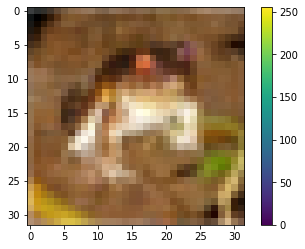

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

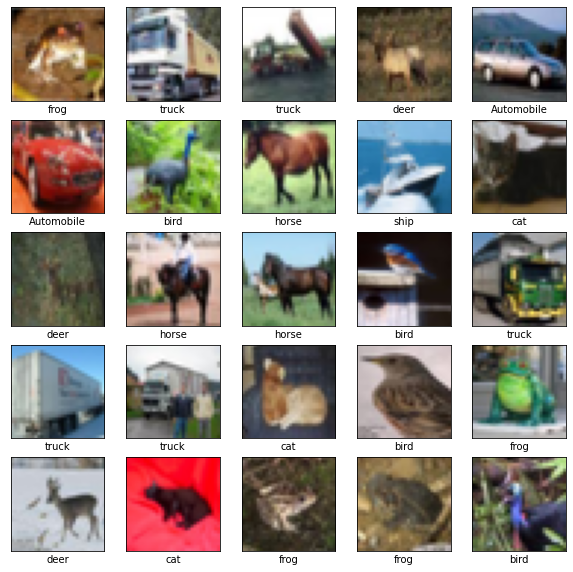

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

#Count plot for training set

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Classes')

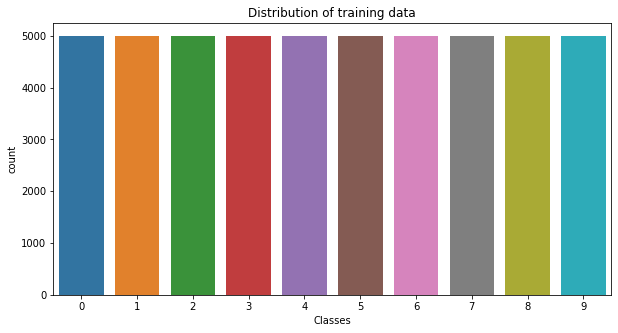

In [5]:
fig, axs = plt.subplots(figsize=(10,5)) 
sns.countplot(train_labels.ravel(), ax=axs)
axs.set_title('Distribution of training data')
axs.set_xlabel('Classes')

## 4. Preprocess the data



The data must be preprocessed before training the network. Here first i  change the dtype into float to make sure can calculate. The labels are change to categorical to make sure correctly classified. And then, I scale the data to make it range from 0-1. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [ ]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

num_classes = 10
train_labels = np_utils.to_categorical(train_labels,num_classes)
test_labels = np_utils.to_categorical(test_labels,num_classes)

# train_images = train_images / 255.0
# test_images = test_images / 255.0
# train_images = tensorflow.keras.utils.normalize(train_images, axis=1)
# test_images  =  tensorflow.keras.utils.normalize(test_images, axis=1)

#z-score
mean = np.mean(train_images,axis=(0,1,2,3))
std = np.std(train_images,axis=(0,1,2,3))
train_images = (train_images-mean)/(std+1e-7)
test_images = (test_images-mean)/(std+1e-7)

## 5. Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

5.1 Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

Basic CNN includes convolution layer, pooing, and flatten into MLP.
Convolution layer use filters to get the features of the image. Pooing deduce the dimension. 
After that, the flatten layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 32 by 32 pixels) to a one-dimensional array (of 32 * 32 = 1024 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
After the pixels are flattened, finally MLP help training to classify the result.The network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.


5.1.1 Here is the first model structure I tried, the final test acc is 86%.

In [ ]:
# model = tf.keras.models.Sequential()
# # model = tf.keras.Sequential([
# #     tf.keras.layers.Flatten(input_shape=(28, 28,3)),
# #     tf.keras.layers.Dense(128, activation='relu'),
# #     tf.keras.layers.Dense(10)
# # ])
# # Add layers
# model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.25))
# # Layer
# model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Dropout(0.25))
# Layer
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(1024, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(10, activation='softmax'))

5.1.2 The below network structure i try achieve acc to be 89%

In [ ]:

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 
baseMapNum = 32
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_images.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

5.2 Data augmentation

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_images)


5.3 Compile the model



In [ ]:
#training
batch_size = 64
epochs=25
opt_rms = keras.optimizers.RMSprop(lr=0.0003,decay=1e-6)
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
history3=model.fit_generator(datagen.flow(train_images,train_labels, batch_size=batch_size),steps_per_epoch=train_images.shape[0] // batch_size,epochs=125,verbose=1,validation_data=(test_images, test_labels))
model.save_weights('cifar10_normal_rms_ep125.h5')

#testing - no kaggle eval
scores = model.evaluate(test_images, test_labels, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
# scores = model.evaluate(test_images, test_labels, batch_size=128, verbose=1)
# print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
781/781 [==============================] - 27s 33ms/step - loss: 0.4381 - accuracy: 0.8786 - val_loss: 0.4845 - val_accuracy: 0.8732
Epoch 2/125
781/781 [==============================] - 25s 32ms/step - loss: 0.4348 - accuracy: 0.8797 - val_loss: 0.5185 - val_accuracy: 0.8620
Epoch 3/125
781/781 [==============================] - 25s 32ms/step - loss: 0.4279 - accuracy: 0.8820 - val_loss: 0.4809 - val_accuracy: 0.8721
Epoch 4/125
781/781 [==============================] - 25s 32ms/step - loss: 0.4290 - accuracy: 0.8819 - val_loss: 0.5313 - val_accuracy: 0.8611
Epoch 5/125
781/781 [==============================] - 25s 32ms/step - loss: 0.4325 - accuracy: 0.8791 - val_loss: 0.5821 - val_accuracy: 0.8497
Epoch 6/125
781/781 [==============================] - 25s 32ms/step - loss: 0.4440 - accuracy: 0.8793 - val_loss: 0.5171 - val_accuracy: 0.8651
Epoch 7/125
781/781 [==============================] - 25s 32ms/step - loss: 0.4262 - accuracy: 0.8818 - val_loss: 0.5009 - val_ac

5.4 Test Result

In [ ]:
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))


Test result: 89.080 loss: 0.426


##6. Evaluate  Accuracy


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


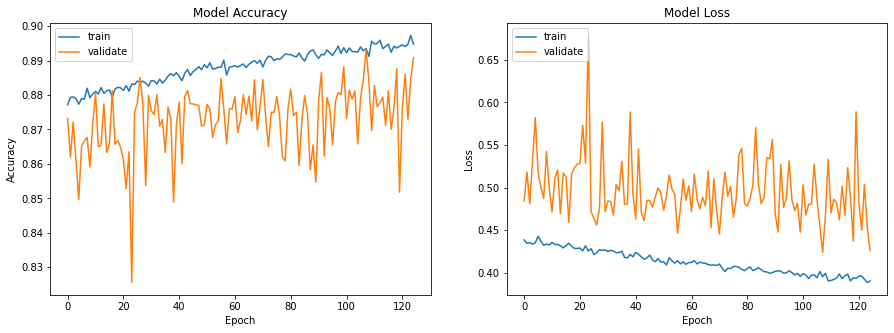

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history3.history.keys())

plotmodelhistory(history3)

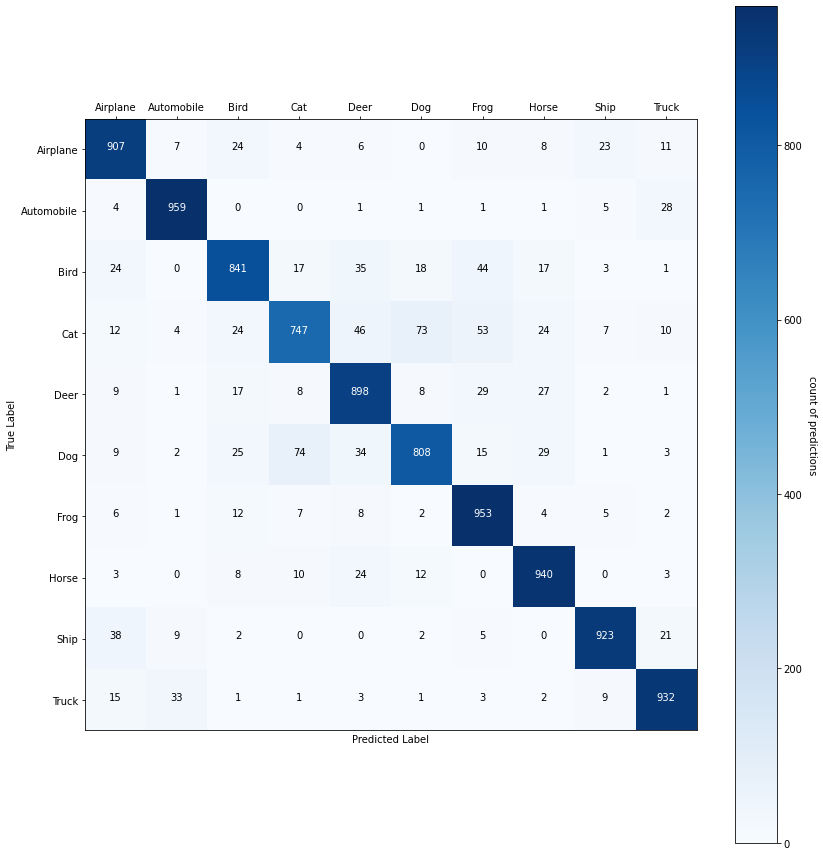

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
#Confusion matrix.
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# make prediction.
pred = model.predict(test_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = test_labels[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [ ]:
#Classification report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1000
           1       0.94      0.96      0.95      1000
           2       0.88      0.84      0.86      1000
           3       0.86      0.75      0.80      1000
           4       0.85      0.90      0.87      1000
           5       0.87      0.81      0.84      1000
           6       0.86      0.95      0.90      1000
           7       0.89      0.94      0.92      1000
           8       0.94      0.92      0.93      1000
           9       0.92      0.93      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



check prediction for true prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

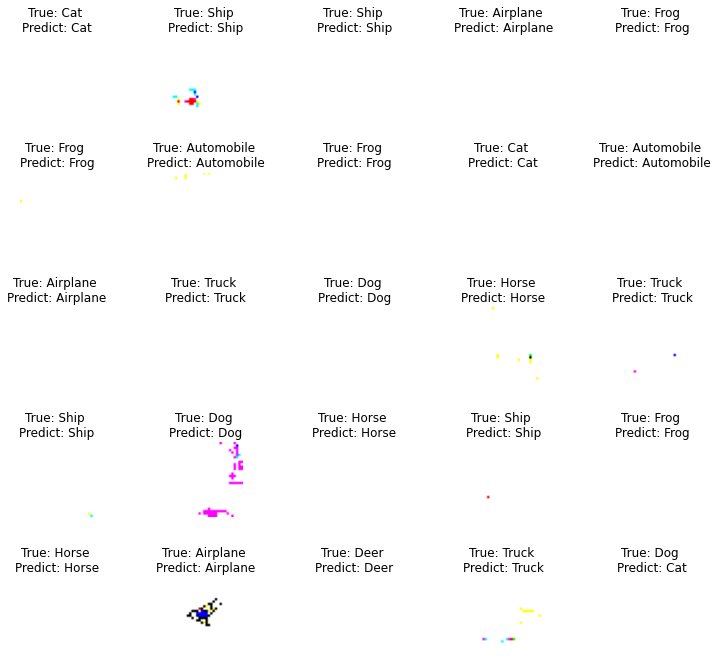

In [ ]:
#Check the predictions.
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

## 7. Save model

In [ ]:
#save model
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(test_images, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 1s 4ms/step - loss: 0.4261 - accuracy: 0.8908
Test loss: 0.42609745264053345
Test accuracy: 0.8907999992370605


###8. Make predictions

With the model trained, I can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layeHere, the model has predicted the label for each image in the testing set. Look at the first prediction:to convert the logits to probabilities, which are easier to interpret. A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. I can see which label has the highest confidence value.

In [ ]:
probability_model = tf.keras.Sequential([model, tensorflow.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
predictions[0]

array([0.08567841, 0.0856795 , 0.0856801 , 0.22647576, 0.08567838,
       0.08798394, 0.085789  , 0.08567808, 0.08567925, 0.08567765],
      dtype=float32)

In [ ]:
np.argmax(predictions[0])  

3

In [ ]:
test_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

Graph this to look at the full set of 10 class predictions.

### Verify predictions

With the model trained, you can use it to make predictions about some images.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Finally, use the test model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(32, 32, 3)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 32, 32, 3)


Now predict the correct label for this image:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[0.08534709 0.08541768 0.08534708 0.08534708 0.08534708 0.08534708
  0.08534708 0.08534708 0.23180562 0.08534708]]


In [ ]:
np.argmax(predictions_single[0])

8